In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

unable to import 'smart_open.gcs', disabling that module


In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
# Import Dataset
#df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
#print(df.target_names.unique())
#df.head()

df = pd.read_csv('./generated/rankgan.csv', quoting = 3).dropna().reset_index(drop=True)

In [4]:
df.columns

Index(['NARRATIVE'], dtype='object')

In [5]:
word_replace_dic = {
        ' vic ':' victim ',
        ' vict ':' victim ',
        ' sus ': ' suspect ',
        ' s1 ': ' suspect ',
        ' v1 ': ' victim ',
        ' loc ': ' location ',
        ' veh ':' vehicle ',
        ' prop ': ' property ',
        ' unk ': ' unknown ',
        ' v ' : ' victim ',
        ' s ': ' suspect ',
        ' ss ': ' suspect ',
        ' susp ': ' suspect ',
        ' remvd ': ' removed ',
        ' victs ': ' victims ',
        ' susps ': ' suspects ',
        ' stillinside ': ' still inside ',
        ' donttell ': ' dont tell ',
        ' veerbal ': ' verbal ',
        ' thransaction ': ' transaction ',
        ' usedcredit ': ' used credit ',
        ' beerbottle ' : ' beer bottle ',
        ' neg ': ' negative ',
        ' cointinuously ': ' continuously ',
        ' lemmon ': ' lemon ',
        ' att ': ' attack '
            }
df['content'] = " " + df['NARRATIVE'].str.lower()+ " "
#df['content'] = df.cleaned.replace(word_replace_dic)#, regex=True)

In [6]:

for key, value in word_replace_dic.items():
    df['content'] = df['content'].str.replace(key, value, 10)


In [7]:
df['NARRATIVE'][2673]

'unk susps osorio susdamaged jones veh for 406 '

In [8]:
df['content'][2673]

' unknown suspects osorio susdamaged jones vehicle for 406  '

In [9]:

for key, value in word_replace_dic.items():
    df['content'] = df['content'].str.replace(key, value, 10)

In [10]:
df[df['content'].str.contains(" vict ")]['content']
#df.columns #= ['DR', 'CRIMETYPE', 'BEGDATE', 'content', 'X', 'Y', 'NARRATIVE_FLAG']

Series([], Name: content, dtype: object)

In [11]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

print(data[:1])

[' unksusp facebookconversation aptparking crawledunder to ']


### Tokenize words and Clean-up text

In [12]:

#I have set deacc=True to remove the punctuations.

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['unksusp', 'aptparking', 'crawledunder', 'to']]


In [13]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['unksusp_aptparking_crawledunder', 'to']


In [14]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['crawledunder']]


### Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
#The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus. Let’s create them.

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1)]]


In [17]:
id2word[0]

'crawledunder'

In [18]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('crawledunder', 1)]]

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [20]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.137*"call" + 0.084*"contact" + 0.043*"torre" + 0.036*"orchestrated" + '
  '0.028*"susp" + 0.021*"require" + 0.018*"violence" + 0.017*"virous" + '
  '0.016*"bike" + 0.016*"ygs"'),
 (1,
  '0.434*"therapy" + 0.045*"disperse" + 0.040*"ca" + 0.033*"prior" + '
  '0.019*"count" + 0.017*"attempt" + 0.017*"perceive" + 0.016*"affect" + '
  '0.015*"hospital" + 0.013*"fledno"'),
 (2,
  '0.117*"deflatable" + 0.054*"rejmoved_vist" + 0.042*"age" + 0.038*"male" + '
  '0.038*"possing" + 0.038*"visible" + 0.032*"place" + 0.029*"sidewalk" + '
  '0.029*"inj" + 0.025*"deuce"'),
 (3,
  '0.144*"ago" + 0.091*"flee" + 0.041*"evil" + 0.029*"front" + '
  '0.022*"employee" + 0.021*"come" + 0.021*"arrive" + 0.020*"nonevidence" + '
  '0.017*"ft" + 0.015*"moringe"'),
 (4,
  '0.067*"member" + 0.053*"arestee" + 0.051*"adult" + 0.051*"leave" + '
  '0.046*"app" + 0.034*"sure" + 0.030*"resid" + 0.026*"steel" + 0.025*"later" '
  '+ 0.021*"regard"'),
 (5,
  '0.078*"sucomme" + 0.070*"dispute" + 0.058*"turn" + 0.05

In [21]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.24422337197527

Coherence Score:  0.4256753007698985


In [22]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.338146  0.330283       1        1  39.961739
7     -0.322982 -0.337454       2        1  23.738338
8     -0.005182 -0.010144       3        1   6.036678
5      0.020671 -0.006198       4        1   5.932649
1      0.022372 -0.005025       5        1   4.377242
3      0.066963  0.000376       6        1   4.014390
9      0.067719  0.000553       7        1   3.865134
11     0.087607  0.003764       8        1   3.073092
0      0.088365  0.003699       9        1   2.923473
4      0.094509  0.004676      10        1   2.611171
10     0.100024  0.005967      11        1   2.243280
2      0.118080  0.009504      12        1   1.222804, topic_info=     Category         Freq         Term        Total  loglift  logprob
6     Default  7700.000000      unknown  7700.000000  30.0000  30.0000
4     Default  8979.000000      suspect  8979.000000  29.0000  29.0000
68    Default  6637.000000       victim  6637.000000  28.0000  28.0000
62    Default  1847.000000      therapy  1847.000000  27.0000  27.0000
8     Default  3386.000000     property  3386.000000  26.0000  26.0000
34    Default  1127.000000     argument  1127.000000  25.0000  25.0000
9     Default  1775.000000      vehicle  1775.000000  24.0000  24.0000
61    Default  1432.000000         take  1432.000000  23.0000  23.0000
158   Default   500.000000     multiple   500.000000  22.0000  22.0000
269   Default   561.000000          ago   561.000000  21.0000  21.0000
87    Default  1271.000000     location  1271.000000  20.0000  20.0000
64    Default   389.000000         call   389.000000  19.0000  19.0000
134   Default   410.000000         fail   410.000000  18.0000  18.0000
74    Default   457.000000         send   457.000000  17.0000  17.0000
85    Default  1434.000000      follewd  1434.000000  16.0000  16.0000
195   Default   449.000000      sucomme   449.000000  15.0000  15.0000
22    Default   313.000000      glenoak   313.000000  14.0000  14.0000
100   Default   356.000000         flee   356.000000  13.0000  13.0000
115   Default   403.000000      dispute   403.000000  12.0000  12.0000
23    Default  1275.000000  orchestrate  1275.000000  11.0000  11.0000
18    Default   771.000000    direction   771.000000  10.0000  10.0000
110   Default  1204.000000         time  1204.000000   9.0000   9.0000
39    Default   347.000000     escalate   347.000000   8.0000   8.0000
50    Default   336.000000         turn   336.000000   7.0000   7.0000
123   Default   666.000000          dir   666.000000   6.0000   6.0000
60    Default   328.000000       strike   328.000000   5.0000   5.0000
312   Default   258.000000      tajpere   258.000000   4.0000   4.0000
14    Default   994.000000       camera   994.000000   3.0000   3.0000
1     Default   240.000000      contact   240.000000   2.0000   2.0000
21    Default   955.000000         gang   955.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
92    Topic12    50.425461          age    51.352657   4.3858  -3.1597
922   Topic12    45.742462         male    46.669666   4.3840  -3.2571
298   Topic12    45.576660      possing    46.503868   4.3839  -3.2608
532   Topic12    45.453129      visible    46.380333   4.3838  -3.2635
982   Topic12    38.035267        place    38.962479   4.3799  -3.4417
1547  Topic12    34.588711     sidewalk    35.515919   4.3776  -3.5366
530   Topic12    34.437481          inj    35.364685   4.3775  -3.5410
518   Topic12    29.538982        deuce    30.466198   4.3731  -3.6945
1894  Topic12    24.984072        alley    25.911280   4.3676  -3.8619
450   Topic12    17.909811         card    18.837027   4.3535  -4.1948
557   Topic12    15.420897     withhold    16.348120   4.3456  -4.3445
1214  Topic12    13.775057         boyz    14.702264   4.3389  -4.4573
1365  Topic12     7.685437   interevene     8.612638   4.2901  -5.0408
2258  

In [23]:

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip

#mallet_path = 'F:\\mallet-2.0.8\\bin\\mallet'
mallet_path = "F:\\mallet-2.0.8\\bin\\mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=12, id2word=id2word)

In [24]:
# Show Topics
pprint(ldamallet.show_topics(num_topics=12, formatted=False))

[(0,
  [('suspect', 0.22529280168443216),
   ('orchestrate', 0.09317015396762732),
   ('entry', 0.03842610869851296),
   ('disperse', 0.02881958152388472),
   ('sunnyslope', 0.02223976839057771),
   ('officer', 0.01868666929859192),
   ('prior', 0.018423476773259638),
   ('excited', 0.011975259902618766),
   ('app', 0.011317278589288065),
   ('sound', 0.011054086063955783)]),
 (1,
  [('unknown', 0.3609254498714653),
   ('property', 0.25089974293059125),
   ('glenoak', 0.04858611825192802),
   ('contronte', 0.0339331619537275),
   ('cumming', 0.02005141388174807),
   ('evil', 0.017095115681233935),
   ('rejmoved_vist', 0.010668380462724936),
   ('deflatable', 0.006426735218508998),
   ('locate', 0.005655526992287918),
   ('discharge', 0.005398457583547558)]),
 (2,
  [('vehicle', 0.21562099871959026),
   ('drive', 0.08130601792573623),
   ('bfmv', 0.03265044814340589),
   ('clarence', 0.026632522407170293),
   ('pursuit', 0.023303457106274007),
   ('damage', 0.019590268886043535),
   ('c

In [25]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)
# Compute Perplexity
#print('\nPerplexity: ', ldamallet.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Coherence Score:  0.39073587554715333


In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

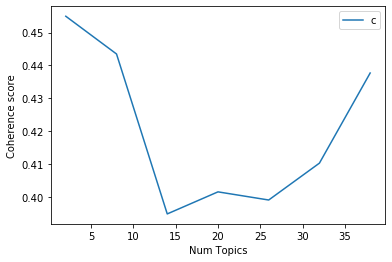

In [28]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()



In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.4549
Num Topics = 8  has Coherence Value of 0.4435
Num Topics = 14  has Coherence Value of 0.3949
Num Topics = 20  has Coherence Value of 0.4016
Num Topics = 26  has Coherence Value of 0.3991
Num Topics = 32  has Coherence Value of 0.4103
Num Topics = 38  has Coherence Value of 0.4377


If the coherence score seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here.

So for further steps I will choose the model with 12 topics itself.


In [30]:
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.325*"victim" + 0.292*"therapy" + 0.025*"arise" + 0.025*"pontius" + '
  '0.014*"appwhere" + 0.013*"fledno" + 0.011*"polic" + 0.009*"irratic" + '
  '0.008*"knowledge" + 0.008*"ft"'),
 (1,
  '0.156*"argument" + 0.066*"send" + 0.057*"dispute" + 0.050*"strike" + '
  '0.048*"escalate" + 0.036*"turn" + 0.036*"ago" + 0.030*"verbal" + '
  '0.029*"arguement" + 0.027*"fight"'),
 (2,
  '0.192*"suspect" + 0.191*"follewd" + 0.069*"sucomme" + 0.033*"force" + '
  '0.032*"entry" + 0.024*"adult" + 0.015*"street" + 0.014*"padrete" + '
  '0.014*"alercation" + 0.010*"visible"'),
 (3,
  '0.162*"time" + 0.123*"suspect" + 0.090*"multiple" + 0.083*"trample" + '
  '0.058*"call" + 0.039*"tajpere" + 0.029*"deflatable" + 0.017*"trampled" + '
  '0.016*"state" + 0.012*"contact"'),
 (4,
  '0.073*"arrest" + 0.057*"fail" + 0.042*"detain" + 0.039*"contronte" + '
  '0.038*"suspect" + 0.036*"bfmv" + 0.027*"pursuit" + 0.026*"ago" + '
  '0.021*"evil" + 0.020*"officer"'),
 (5,
  '0.121*"camera" + 0.111*"wasupset" +

In [31]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
C:\Users\Samira\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11    -0.060932  0.257381       1        1  8.732170
7     -0.057668  0.262686       2        1  8.571193
2     -0.045388  0.256289       3        1  8.444045
4      0.188245 -0.049257       4        1  8.389890
3      0.107119  0.084924       5        1  8.386749
10     0.160215 -0.090264       6        1  8.367122
8      0.117189 -0.085053       7        1  8.322027
0      0.176308 -0.020362       8        1  8.291812
9      0.141948 -0.211270       9        1  8.281554
6      0.065367 -0.129663      10        1  8.143043
5     -0.396771 -0.142204      11        1  8.054116
1     -0.395632 -0.133206      12        1  8.016279, topic_info=     Category         Freq          Term        Total  loglift  logprob
6     Default  6849.000000       unknown  6849.000000  30.0000  30.0000
68    Default  5852.000000        victim  5852.000000  29.0000  29.0000
4     Default  8084.000000       suspect  8084.000000  28.0000  28.0000
8     Default  3091.000000      property  3091.000000  27.0000  27.0000
62    Default  1999.000000       therapy  1999.000000  26.0000  26.0000
9     Default  1770.000000       vehicle  1770.000000  25.0000  25.0000
85    Default  1334.000000       follewd  1334.000000  24.0000  24.0000
110   Default  1127.000000          time  1127.000000  23.0000  23.0000
34    Default  1130.000000      argument  1130.000000  22.0000  22.0000
14    Default   895.000000        camera   895.000000  21.0000  21.0000
21    Default   833.000000          gang   833.000000  20.0000  20.0000
23    Default  1100.000000   orchestrate  1100.000000  19.0000  19.0000
30    Default   822.000000      wasupset   822.000000  18.0000  18.0000
87    Default  1113.000000      location  1113.000000  17.0000  17.0000
18    Default   677.000000     direction   677.000000  16.0000  16.0000
19    Default   667.000000         drive   667.000000  15.0000  15.0000
158   Default   627.000000      multiple   627.000000  14.0000  14.0000
5     Default   575.000000       trample   575.000000  13.0000  13.0000
123   Default   558.000000           dir   558.000000  12.0000  12.0000
94    Default   522.000000        arrest   522.000000  11.0000  11.0000
195   Default   487.000000       sucomme   487.000000  10.0000  10.0000
12    Default   667.000000      arresete   667.000000   9.0000   9.0000
74    Default   475.000000          send   475.000000   8.0000   8.0000
381   Default   462.000000            pc   462.000000   7.0000   7.0000
115   Default   416.000000       dispute   416.000000   6.0000   6.0000
134   Default   403.000000          fail   403.000000   5.0000   5.0000
64    Default   402.000000          call   402.000000   4.0000   4.0000
22    Default   378.000000       glenoak   378.000000   3.0000   3.0000
60    Default   366.000000        strike   366.000000   2.0000   2.0000
100   Default   339.000000          flee   339.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1078  Topic12    17.020229         house    17.020229   2.5237  -6.1261
257   Topic12    13.015469          prov    13.015469   2.5237  -6.3944
358   Topic12    12.014279       corisco    12.014279   2.5237  -6.4744
2976  Topic12    12.014279            dr    12.014279   2.5237  -6.4744
452   Topic12    12.014279       ductape    12.014279   2.5237  -6.4744
916   Topic12    11.013089      overbody    11.013089   2.5237  -6.5614
2693  Topic12    10.011899           fly    10.011899   2.5237  -6.6567
871   Topic12    10.011899       provoke    10.011899   2.5237  -6.6567
3021  Topic12     9.010709        collin     9.010709   2.5237  -6.7621
974   Topic12     9.010709        approx     9.010709   2.5237  -6.7621
1012  Topic12     8.009519        sliver     8.009519   2.5237  -6.8799
1464  Topic12     8.009519         posse     8.009519   2.5237  -6.8799
3686  Topic12     8.009519       onceale     8.

In [32]:
# Compute Perplexity
print('\nPerplexity: ', model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.



Perplexity:  nan


C:\Users\Samira\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1108: RuntimeWarning: invalid value encountered in multiply
  score += np.sum((self.eta - _lambda) * Elogbeta)
C:\Users\Samira\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1109: RuntimeWarning: invalid value encountered in subtract
  score += np.sum(gammaln(_lambda) - gammaln(self.eta))


## Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [33]:
def format_two_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                topic_num0 = topic_num
                prop_topic0 = prop_topic
                wp0 = ldamodel.show_topic(topic_num0)
                topic_keywords0 = ", ".join([word for word, prop in wp0])
            elif j == 1:  # => dominant topic
                topic_num1 = topic_num
                prop_topic1 = prop_topic
                wp1 = ldamodel.show_topic(topic_num1)
                topic_keywords1 = ", ".join([word for word, prop in wp1])
            else:
                break
        sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num0), round(prop_topic0,4), topic_keywords0,int(topic_num1), round(prop_topic1,4), topic_keywords1]), ignore_index=True)
    sent_topics_df.columns = ['Dominant_Topic0', 'Perc_Contribution0', 'Topic_Keywords0', 'Dominant_Topic1', 'Perc_Contribution1', 'Topic_Keywords1']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#df_two_topic_sents_keywords = format_two_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_two_topic_sents_keywords = format_two_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_two_dominant_topic = df_two_topic_sents_keywords.reset_index()
df_two_dominant_topic.columns = ['Document_No', 'Dominant_Topic0', 'Topic_Perc_Contrib0', 'Keywords0', 'Dominant_Topic1', 'Topic_Perc_Contrib1', 'Keywords1', 'Text']

# Show
df_two_dominant_topic.head(10)

,Document_No,Dominant_Topic0,Topic_Perc_Contrib0,Keywords0,Dominant_Topic1,Topic_Perc_Contrib1,Keywords1,Text
0,0,4.0,0.1013,"suspect, follewd, arresete, conviciton, steel,...",0.0,0.0817,"suspect, orchestrate, entry, disperse, sunnysl...",unksusp facebookconversation aptparking crawl...
1,1,8.0,0.1240,"time, multiple, trample, victim, suspect, call...",9.0,0.0982,"victim, suspect, unknown, location, arge, inju...",unknown suspect outbuilding was contacted pol...
2,2,1.0,0.1017,"unknown, property, glenoak, contronte, cumming...",2.0,0.0975,"vehicle, drive, bfmv, clarence, pursuit, damag...",unknown suspect t6ook victims property got to...
3,3,1.0,0.0998,"unknown, property, glenoak, contronte, cumming...",3.0,0.0957,"location, arrest, suspect, fail, orchestrate, ...",unknown suspects t6ook victims property detai...
4,4,11.0,0.1739,"camera, wasupset, pc, arresete, travel, bus, t...",5.0,0.1089,"unknown, property, direction, dir, flee, gaffe...",suspect orchestrated blowdryer worught stepsi...
5,5,7.0,0.2955,"argument, send, dispute, strike, escalate, ago...",8.0,0.0826,"time, multiple, trample, victim, suspect, call...",suspect phan turned co was argument argument ...
6,6,6.0,0.1201,"victim, therapy, assisstance, pontius, fledno,...",11.0,0.1054,"camera, wasupset, pc, arresete, travel, bus, t...",unknown suspect t6ook victims property from v...
7,7,5.0,0.0926,"unknown, property, direction, dir, flee, gaffe...",1.0,0.0904,"unknown, property, glenoak, contronte, cumming...",unknown suspect t6ook vehicle
8,8,8.0,0.0996,"time, multiple, trample, victim, suspect, call...",11.0,0.0975,"camera, wasupset, pc, arresete, travel, bus, t...",suspect phan called one obsd suspect retrieve...
9,9,6.0,0.1202,"victim, therapy, assisstance, pontius, fledno,...",7.0,0.0939,"argument, send, dispute, strike, escalate, ago...",victim weer footwith assisstance andsocial as...


In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)
df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.1013,"suspect, follewd, arresete, conviciton, steel,...",unksusp facebookconversation aptparking crawl...
1,1,8.0,0.1240,"time, multiple, trample, victim, suspect, call...",unknown suspect outbuilding was contacted pol...
2,2,1.0,0.1017,"unknown, property, glenoak, contronte, cumming...",unknown suspect t6ook victims property got to...
3,3,1.0,0.0998,"unknown, property, glenoak, contronte, cumming...",unknown suspects t6ook victims property detai...
4,4,11.0,0.1739,"camera, wasupset, pc, arresete, travel, bus, t...",suspect orchestrated blowdryer worught stepsi...
5,5,7.0,0.2955,"argument, send, dispute, strike, escalate, ago...",suspect phan turned co was argument argument ...
6,6,6.0,0.1201,"victim, therapy, assisstance, pontius, fledno,...",unknown suspect t6ook victims property from v...
7,7,5.0,0.0926,"unknown, property, direction, dir, flee, gaffe...",unknown suspect t6ook vehicle
8,8,8.0,0.0996,"time, multiple, trample, victim, suspect, call...",suspect phan called one obsd suspect retrieve...
9,9,6.0,0.1202,"victim, therapy, assisstance, pontius, fledno,...",victim weer footwith assisstance andsocial as...


## Find the most representative document for each topic

Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents a given topic has contributed to the most and infer the topic by reading that document. 

In [35]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2169,"suspect, orchestrate, entry, disperse, sunnysl...",suspect orchestrated blowdryer worught stepsi...
1,1.0,0.1739,"unknown, property, glenoak, contronte, cumming...",victim weer alercation as wanton inj sujsp we...
2,2.0,0.2215,"vehicle, drive, bfmv, clarence, pursuit, damag...",male ingram 071314 above abve 3725500 050914 ...
3,3.0,0.2056,"location, arrest, suspect, fail, orchestrate, ...",unknown suspect rejmoved vists schoolyard vic...
4,4.0,0.2109,"suspect, follewd, arresete, conviciton, steel,...",suspects orchestrated gardenersusp 0815hrs re...


In [36]:
sent_two_topics_sorteddf_mallet = pd.DataFrame()

sent_two_topics_outdf_grpd = df_two_topic_sents_keywords.groupby('Dominant_Topic0')

for i, grp in sent_two_topics_outdf_grpd:
    sent_two_topics_sorteddf_mallet = pd.concat([sent_two_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution0'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_two_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
#sent_two_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_two_topics_sorteddf_mallet.head()

,Dominant_Topic0,Perc_Contribution0,Topic_Keywords0,Dominant_Topic1,Perc_Contribution1,Topic_Keywords1,0
0,0.0,0.2169,"suspect, orchestrate, entry, disperse, sunnysl...",10.0,0.1088,"gang, suspect, sucomme, victim, member, injunc...",suspect orchestrated blowdryer worught stepsi...
1,1.0,0.1739,"unknown, property, glenoak, contronte, cumming...",11.0,0.1479,"camera, wasupset, pc, arresete, travel, bus, t...",victim weer alercation as wanton inj sujsp we...
2,2.0,0.2215,"vehicle, drive, bfmv, clarence, pursuit, damag...",5.0,0.0918,"unknown, property, direction, dir, flee, gaffe...",male ingram 071314 above abve 3725500 050914 ...
3,3.0,0.2056,"location, arrest, suspect, fail, orchestrate, ...",11.0,0.1017,"camera, wasupset, pc, arresete, travel, bus, t...",unknown suspect rejmoved vists schoolyard vic...
4,4.0,0.2109,"suspect, follewd, arresete, conviciton, steel,...",0.0,0.1033,"suspect, orchestrate, entry, disperse, sunnysl...",suspects orchestrated gardenersusp 0815hrs re...


## Topic distribution across documents

Finally, we want to understand the volume and distribution of topics in order to judge how widely it was discussed. The below table exposes that information.

In [37]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"suspect, follewd, arresete, conviciton, steel,...",897.0,0.0898
1,8.0,"time, multiple, trample, victim, suspect, call...",1171.0,0.1173
2,1.0,"unknown, property, glenoak, contronte, cumming...",913.0,0.0914
3,1.0,"unknown, property, glenoak, contronte, cumming...",744.0,0.0745
4,11.0,"camera, wasupset, pc, arresete, travel, bus, t...",682.0,0.0683
5,7.0,"argument, send, dispute, strike, escalate, ago...",972.0,0.0974
6,6.0,"victim, therapy, assisstance, pontius, fledno,...",956.0,0.0958
7,5.0,"unknown, property, direction, dir, flee, gaffe...",888.0,0.0889
8,8.0,"time, multiple, trample, victim, suspect, call...",798.0,0.0799
9,6.0,"victim, therapy, assisstance, pontius, fledno,...",468.0,0.0469


In [38]:
# Show
df_dominant_topics.head(12)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,4.0,"suspect, follewd, arresete, conviciton, steel,...",897.0,0.0898
1,8.0,"time, multiple, trample, victim, suspect, call...",1171.0,0.1173
2,1.0,"unknown, property, glenoak, contronte, cumming...",913.0,0.0914
3,1.0,"unknown, property, glenoak, contronte, cumming...",744.0,0.0745
4,11.0,"camera, wasupset, pc, arresete, travel, bus, t...",682.0,0.0683
5,7.0,"argument, send, dispute, strike, escalate, ago...",972.0,0.0974
6,6.0,"victim, therapy, assisstance, pontius, fledno,...",956.0,0.0958
7,5.0,"unknown, property, direction, dir, flee, gaffe...",888.0,0.0889
8,8.0,"time, multiple, trample, victim, suspect, call...",798.0,0.0799
9,6.0,"victim, therapy, assisstance, pontius, fledno,...",468.0,0.0469


In [39]:
df_dominant_topic.to_csv('df_dominant_topics_rankgan.csv')